In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import tqdm as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


import copy
import random
import time


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm.tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    num_classes = dict()

    with torch.no_grad():

        for (x, y) in tqdm.tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            top_pred = y_pred.argmax(1).cpu().data.numpy()
            for c in top_pred:
                if c not in num_classes:
                    num_classes[c] = 1
                else:
                    num_classes[c] += 1

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), num_classes

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

class MyMLP(nn.Module):
    def __init__(self, D, L, res, activ, norm, D_in = None, D_out=None):
        super().__init__()
        assert(activ in ['lin', 'relu','tanh'])
        assert(norm in ['', 'LN','BN1','BN2'])
        if not D_in:
            D_in = D
        if not D_out:
            D_out = D
        self.norm = norm
        self.activ = activ
        self.fcs = [nn.Linear(D, D) for l in range(L)]
        self.fcs[0] = nn.Linear(D_in,D)
        self.fcs[-1] = nn.Linear(D,D_out)
        for fc in self.fcs:
            shape = fc.weight.shape
            weights = 1.0/np.sqrt(shape[1])* torch.normal(0, 1, size=shape)
            fc.weight.data = weights
        
        for li,fc in enumerate(self.fcs):
            self.add_module("fc_"+str(li), fc)
        self.L = L
        self.D = D
        self.res = res
        
    def activation(self, h):
        if self.activ=='lin':
            return h
        elif self.activ=='relu':
            return F.relu(h)
        elif self.activ=='tanh':
            return torch.tanh(h)
    
    def normalize(self, h):
        if self.norm=='LN':
            # h = h - h.mean(1,keepdim=True)
            h = h / torch.norm(h,dim=1,keepdim=True)
        if self.norm=='BN2':
            h = h - h.mean(0,keepdim=True)
            h = h / torch.norm(h,dim=0,keepdim=True)
        if self.norm=='BN1':
            h = h / torch.norm(h,dim=0,keepdim=True)
        return h 
        
    def layer_update(self, l,h):
        h2 = h
        if l>0:
            h2 = self.normalize(h2)
        h2 = self.activation(h2)
        h2 = self.fcs[l](h2)
        if l==self.L-1:
            h2 = torch.softmax(h2,1)
        return h2


    def full_forward(self, h):
        h = h.view(h.shape[0],-1) # flatten images to vectors
        H = [h.cpu().data.numpy()]
        for l in range(self.L):
            h = self.layer_update(l,h)
            H.append(h.cpu().data.numpy())
        return H
    
    def forward(self, h):
        h = h.view(h.shape[0],-1) #  # flatten images to vectors
        for l in range(self.L):
            h = self.layer_update(l,h)
        return h
    
def show_layers(Hidden, Num=None,subplot=True,title=False,save_path=None):
    if not Num:
        Num = len(Hidden)
    inds = np.linspace(0,len(Hidden)-1,Num).astype(np.int32)
    Hidden = [Hidden[i] for i in inds]
    if subplot:
        fig = plt.figure(figsize=(2*Num,2))
    for Hi,(l,H) in enumerate(zip(inds,Hidden)):
        while H.shape[0]==1:
            H = H[0]
        # H = H.data.numpy()
        if subplot:
            ax = fig.add_subplot(1,Num,Hi+1)
        else:
            plt.clf()
            ax = plt.gca()
        
        ax.scatter(H[0],H[1],2)
        if title:
            ax.set_title(f'Layer = {Hi+1}')
                      

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624
Number of training examples: 12665
Number of testing examples: 2115


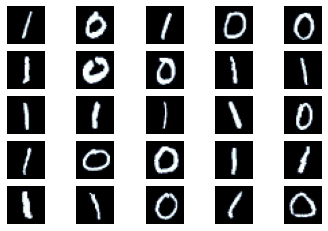

In [305]:
ROOT = '.data'
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

Classes = list(range(10))
Classes = [0,1]
train_data = [(x,y) for x,y in train_data if y in Classes]
test_data = [(x,y) for x,y in test_data if y in Classes]

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

N_IMAGES = 25

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [250]:
def class_freq(num_classes,classes, prob=True, label = ''):
    freq = np.zeros(len(classes))
    for c, n in num_classes.items():
        freq[c] = n
    if prob:
        freq = freq / np.sum(freq)
    s = ', '.join([f'f[{c}]={f:.3f}' for f in freq])
    s = label + ': ' + s
    print(s)
    return s
def calc_H(num_classes, classes):
    freq = np.zeros(len(classes))
    for c, n in num_classes.items():
        freq[c] = n
    freq = freq + 1e-2/sum(freq) # to avoid NaN in log
    freq = freq / np.sum(freq)
    tv = np.mean(abs(freq - 1.0/len(freq)))
    return -np.sum(freq * np.log2(freq)),tv

repeat = 5
EPOCHS = 10

D_IN = 28*28
num_classes = len(Classes)
WIDTH = 200
LAYERS = 15

RES = .0
BATCH_SIZE = 16
ACTIVATION = 'relu'
NORM = ''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.DataFrame(columns=['epoch','bath_size','width','layers','normalization','activation', 'H_train','H_val', 'TV_train','TV_test', 'train_acc','val_acc','train_loss','val_loss',])

for NORM in ['','BN2']:
    for ri in range(repeat):
        train_iterator = data.DataLoader(train_data,batch_size=BATCH_SIZE)
        test_iterator = data.DataLoader(test_data,batch_size=BATCH_SIZE)

        criterion = nn.CrossEntropyLoss().to(device)
        model = MyMLP(L=LAYERS,D=WIDTH,res=RES,activ=ACTIVATION, norm=NORM, D_in=D_IN, D_out=num_classes)
        model = model.to(device)

        best_valid_loss = float('inf')
        optimizer = optim.SGD(model.parameters(),lr=1e-3)


        for epoch in range(EPOCHS+1):
            if epoch>0:
                train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
            valid_loss, valid_acc, freq = evaluate(model, test_iterator, criterion, device)
            class_freq(freq, Classes, 'Valid. freqs')
            # _, _, num_classes = evaluate(model, train_iterator, criterion, device)
            _, _, train_num_classes = evaluate(model, train_iterator, criterion, device)
            _, _, test_num_classes = evaluate(model, test_iterator, criterion, device)
            H_train,TV_train = calc_H(train_num_classes, Classes)
            H_test,TV_test = calc_H(test_num_classes, Classes)
            df.loc[len(df),:] = (epoch, BATCH_SIZE,WIDTH,LAYERS, NORM,ACTIVATION,H_train,TV_test, TV_train,TV_test, train_acc, valid_acc, train_loss, valid_loss)
            if epoch==0:
                continue

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), 'tut1-model.pt')

            print(f'Epoch: {epoch+1}\tTrain Loss: {train_loss:.5f}\tTrain Acc: {train_acc}\tVal. Loss: {valid_loss:.5f}\t Val. Acc: {valid_acc:.5f}')
            # sample_plot(10,2)
            # plt.show()

: f[0]=1.000, f[0]=0.000


: f[0]=0.000, f[0]=1.000


Epoch: 2	Train Loss: 0.69363	Train Acc: 0.4852956650082511	Val. Loss: 0.69253	 Val. Acc: 0.53791


: f[1]=0.000, f[1]=1.000


Epoch: 3	Train Loss: 0.69186	Train Acc: 0.5324074074324935	Val. Loss: 0.69082	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 4	Train Loss: 0.69035	Train Acc: 0.5324074074324935	Val. Loss: 0.68901	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 5	Train Loss: 0.68854	Train Acc: 0.5324074074324935	Val. Loss: 0.68661	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 6	Train Loss: 0.68594	Train Acc: 0.5324074074324935	Val. Loss: 0.68276	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 7	Train Loss: 0.68121	Train Acc: 0.5324074074324935	Val. Loss: 0.67490	 Val. Acc: 0.53744


: f[0]=0.014, f[0]=0.986


Epoch: 8	Train Loss: 0.67026	Train Acc: 0.5328019781395642	Val. Loss: 0.65713	 Val. Acc: 0.55107


: f[0]=0.440, f[0]=0.560


Epoch: 9	Train Loss: 0.64502	Train Acc: 0.8074494949494949	Val. Loss: 0.61851	 Val. Acc: 0.97697


: f[0]=0.459, f[0]=0.541


Epoch: 10	Train Loss: 0.59500	Train Acc: 0.9594381313131313	Val. Loss: 0.54793	 Val. Acc: 0.99483


: f[0]=0.463, f[0]=0.537


Epoch: 11	Train Loss: 0.50300	Train Acc: 0.9801136363636364	Val. Loss: 0.42485	 Val. Acc: 0.99577


: f[1]=0.000, f[1]=1.000


: f[1]=0.000, f[1]=1.000


Epoch: 2	Train Loss: 0.69156	Train Acc: 0.5324074074324935	Val. Loss: 0.69073	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 3	Train Loss: 0.69071	Train Acc: 0.5324074074324935	Val. Loss: 0.68984	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 4	Train Loss: 0.68997	Train Acc: 0.5324074074324935	Val. Loss: 0.68886	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 5	Train Loss: 0.68904	Train Acc: 0.5324074074324935	Val. Loss: 0.68746	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 6	Train Loss: 0.68763	Train Acc: 0.5324074074324935	Val. Loss: 0.68522	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 7	Train Loss: 0.68497	Train Acc: 0.5324074074324935	Val. Loss: 0.68080	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 8	Train Loss: 0.67945	Train Acc: 0.5324074074324935	Val. Loss: 0.67139	 Val. Acc: 0.53744


: f[0]=0.389, f[0]=0.611


Epoch: 9	Train Loss: 0.66591	Train Acc: 0.6405460858585859	Val. Loss: 0.64650	 Val. Acc: 0.92387


: f[0]=0.463, f[0]=0.537


Epoch: 10	Train Loss: 0.62593	Train Acc: 0.9452335858585859	Val. Loss: 0.57201	 Val. Acc: 0.99013


: f[0]=0.466, f[0]=0.534


Epoch: 11	Train Loss: 0.52475	Train Acc: 0.9786931818181818	Val. Loss: 0.44613	 Val. Acc: 0.99436


: f[0]=1.000, f[0]=0.000


: f[0]=0.014, f[0]=0.986


Epoch: 2	Train Loss: 0.69307	Train Acc: 0.5274358165234027	Val. Loss: 0.69151	 Val. Acc: 0.55107


: f[1]=0.000, f[1]=1.000


Epoch: 3	Train Loss: 0.69079	Train Acc: 0.5327230639981501	Val. Loss: 0.68926	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 4	Train Loss: 0.68885	Train Acc: 0.5324074074324935	Val. Loss: 0.68662	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 5	Train Loss: 0.68628	Train Acc: 0.5324074074324935	Val. Loss: 0.68315	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 6	Train Loss: 0.68247	Train Acc: 0.5324074074324935	Val. Loss: 0.67720	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 7	Train Loss: 0.67526	Train Acc: 0.5324074074324935	Val. Loss: 0.66661	 Val. Acc: 0.53744


: f[0]=0.407, f[0]=0.593


Epoch: 8	Train Loss: 0.66204	Train Acc: 0.6841066919191919	Val. Loss: 0.64714	 Val. Acc: 0.94361


: f[0]=0.454, f[0]=0.546


Epoch: 9	Train Loss: 0.63578	Train Acc: 0.9354482323232324	Val. Loss: 0.60581	 Val. Acc: 0.98778


: f[0]=0.463, f[0]=0.537


Epoch: 10	Train Loss: 0.57724	Train Acc: 0.9804292929292929	Val. Loss: 0.51559	 Val. Acc: 0.99295


: f[0]=0.463, f[0]=0.537


Epoch: 11	Train Loss: 0.47105	Train Acc: 0.9847695707070707	Val. Loss: 0.40550	 Val. Acc: 0.99436


: f[0]=1.000, f[0]=0.000


: f[0]=1.000, f[0]=0.000


Epoch: 2	Train Loss: 0.69332	Train Acc: 0.46759259260513564	Val. Loss: 0.69207	 Val. Acc: 0.46256


: f[1]=0.000, f[1]=1.000


Epoch: 3	Train Loss: 0.69151	Train Acc: 0.6009837963213824	Val. Loss: 0.68994	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 4	Train Loss: 0.68939	Train Acc: 0.5324074074324935	Val. Loss: 0.68695	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 5	Train Loss: 0.68628	Train Acc: 0.5324074074324935	Val. Loss: 0.68246	 Val. Acc: 0.53744


: f[0]=0.031, f[0]=0.969


Epoch: 6	Train Loss: 0.68124	Train Acc: 0.5329598064223925	Val. Loss: 0.67481	 Val. Acc: 0.56845


: f[0]=0.350, f[0]=0.650


Epoch: 7	Train Loss: 0.67154	Train Acc: 0.654233305291696	Val. Loss: 0.65919	 Val. Acc: 0.88769


: f[0]=0.449, f[0]=0.551


Epoch: 8	Train Loss: 0.65217	Train Acc: 0.8993055555555556	Val. Loss: 0.62961	 Val. Acc: 0.98543


: f[0]=0.461, f[0]=0.539


Epoch: 9	Train Loss: 0.61252	Train Acc: 0.9656723484848485	Val. Loss: 0.56364	 Val. Acc: 0.99577


: f[0]=0.464, f[0]=0.536


Epoch: 10	Train Loss: 0.52153	Train Acc: 0.9774305555555556	Val. Loss: 0.44124	 Val. Acc: 0.99624


: f[0]=0.463, f[0]=0.537


Epoch: 11	Train Loss: 0.42193	Train Acc: 0.9834280303030303	Val. Loss: 0.37596	 Val. Acc: 0.99718


: f[0]=1.000, f[0]=0.000


: f[0]=0.153, f[0]=0.847


Epoch: 2	Train Loss: 0.69241	Train Acc: 0.5812991021407975	Val. Loss: 0.69086	 Val. Acc: 0.69173


: f[1]=0.000, f[1]=1.000


Epoch: 3	Train Loss: 0.69008	Train Acc: 0.5441656145032006	Val. Loss: 0.68797	 Val. Acc: 0.53744


: f[1]=0.000, f[1]=1.000


Epoch: 4	Train Loss: 0.68712	Train Acc: 0.5324074074324935	Val. Loss: 0.68371	 Val. Acc: 0.53744


: f[0]=0.004, f[0]=0.996


Epoch: 5	Train Loss: 0.68214	Train Acc: 0.5324863215739076	Val. Loss: 0.67615	 Val. Acc: 0.54120


: f[0]=0.330, f[0]=0.670


Epoch: 6	Train Loss: 0.67262	Train Acc: 0.626201248605444	Val. Loss: 0.66177	 Val. Acc: 0.86795


: f[0]=0.444, f[0]=0.556


Epoch: 7	Train Loss: 0.65456	Train Acc: 0.8964821829488783	Val. Loss: 0.63405	 Val. Acc: 0.97885


: f[0]=0.462, f[0]=0.538


Epoch: 8	Train Loss: 0.61408	Train Acc: 0.9723011363636364	Val. Loss: 0.56594	 Val. Acc: 0.99436


: f[0]=0.464, f[0]=0.536


Epoch: 9	Train Loss: 0.52153	Train Acc: 0.9791666666666666	Val. Loss: 0.44968	 Val. Acc: 0.99530


: f[0]=0.463, f[0]=0.537


Epoch: 10	Train Loss: 0.43105	Train Acc: 0.9847695707070707	Val. Loss: 0.39275	 Val. Acc: 0.99624


: f[0]=0.463, f[0]=0.537


Epoch: 11	Train Loss: 0.38553	Train Acc: 0.9880839646464646	Val. Loss: 0.36120	 Val. Acc: 0.99624


: f[0]=0.052, f[0]=0.948


: f[0]=0.067, f[0]=0.933


Epoch: 2	Train Loss: 0.68808	Train Acc: 0.5418771044021905	Val. Loss: 0.68204	 Val. Acc: 0.55655


: f[0]=0.145, f[0]=0.855


Epoch: 3	Train Loss: 0.67314	Train Acc: 0.5944514590682406	Val. Loss: 0.66606	 Val. Acc: 0.63565


: f[0]=0.245, f[0]=0.755


Epoch: 4	Train Loss: 0.65228	Train Acc: 0.6919718013718875	Val. Loss: 0.63985	 Val. Acc: 0.74765


: f[0]=0.348, f[0]=0.652


Epoch: 5	Train Loss: 0.61963	Train Acc: 0.804880401251292	Val. Loss: 0.60518	 Val. Acc: 0.84633


: f[0]=0.396, f[0]=0.604


Epoch: 6	Train Loss: 0.57816	Train Acc: 0.8842329545454546	Val. Loss: 0.56358	 Val. Acc: 0.89615


: f[0]=0.422, f[0]=0.578


Epoch: 7	Train Loss: 0.53624	Train Acc: 0.9272411616161617	Val. Loss: 0.52658	 Val. Acc: 0.92951


: f[0]=0.438, f[0]=0.562


Epoch: 8	Train Loss: 0.49968	Train Acc: 0.9511521464646465	Val. Loss: 0.49774	 Val. Acc: 0.94173


: f[0]=0.443, f[0]=0.557


Epoch: 9	Train Loss: 0.46947	Train Acc: 0.9667771464646465	Val. Loss: 0.47501	 Val. Acc: 0.95301


: f[0]=0.447, f[0]=0.553


Epoch: 10	Train Loss: 0.44504	Train Acc: 0.9770359848484849	Val. Loss: 0.45867	 Val. Acc: 0.95254


: f[0]=0.452, f[0]=0.548


Epoch: 11	Train Loss: 0.42540	Train Acc: 0.9839804292929293	Val. Loss: 0.44415	 Val. Acc: 0.95630


: f[1]=0.608, f[1]=0.392


: f[1]=0.454, f[1]=0.546


Epoch: 2	Train Loss: 0.68441	Train Acc: 0.5808957631916108	Val. Loss: 0.67378	 Val. Acc: 0.65664


: f[0]=0.418, f[0]=0.582


Epoch: 3	Train Loss: 0.65927	Train Acc: 0.7344889871098779	Val. Loss: 0.64685	 Val. Acc: 0.77851


: f[0]=0.429, f[0]=0.571


Epoch: 4	Train Loss: 0.62392	Train Acc: 0.8357972082014036	Val. Loss: 0.60339	 Val. Acc: 0.87077


: f[0]=0.428, f[0]=0.572


Epoch: 5	Train Loss: 0.58006	Train Acc: 0.8945268658977567	Val. Loss: 0.56342	 Val. Acc: 0.90210


: f[0]=0.442, f[0]=0.558


Epoch: 6	Train Loss: 0.53650	Train Acc: 0.9259785353535354	Val. Loss: 0.52438	 Val. Acc: 0.92199


: f[0]=0.448, f[0]=0.552


Epoch: 7	Train Loss: 0.49788	Train Acc: 0.9484690656565656	Val. Loss: 0.49560	 Val. Acc: 0.92669


: f[0]=0.452, f[0]=0.548


Epoch: 8	Train Loss: 0.46667	Train Acc: 0.962042297979798	Val. Loss: 0.47412	 Val. Acc: 0.93233


: f[0]=0.453, f[0]=0.547


Epoch: 9	Train Loss: 0.44171	Train Acc: 0.9720643939393939	Val. Loss: 0.45610	 Val. Acc: 0.93703


: f[0]=0.458, f[0]=0.542


Epoch: 10	Train Loss: 0.42190	Train Acc: 0.9802714646464646	Val. Loss: 0.44456	 Val. Acc: 0.93875


: f[0]=0.461, f[0]=0.539


Epoch: 11	Train Loss: 0.40651	Train Acc: 0.9848484848484849	Val. Loss: 0.43309	 Val. Acc: 0.94079


: f[1]=0.493, f[1]=0.507


: f[1]=0.390, f[1]=0.610


Epoch: 2	Train Loss: 0.68657	Train Acc: 0.5621580387456249	Val. Loss: 0.68081	 Val. Acc: 0.61795


: f[0]=0.357, f[0]=0.643


Epoch: 3	Train Loss: 0.66727	Train Acc: 0.6854482323232324	Val. Loss: 0.66005	 Val. Acc: 0.71460


: f[0]=0.374, f[0]=0.626


Epoch: 4	Train Loss: 0.63762	Train Acc: 0.7897727272727273	Val. Loss: 0.62388	 Val. Acc: 0.81720


: f[0]=0.384, f[0]=0.616


Epoch: 5	Train Loss: 0.59821	Train Acc: 0.8675031565656566	Val. Loss: 0.58501	 Val. Acc: 0.87124


: f[0]=0.407, f[0]=0.593


Epoch: 6	Train Loss: 0.55604	Train Acc: 0.9049084595959596	Val. Loss: 0.54679	 Val. Acc: 0.90132


: f[0]=0.410, f[0]=0.590


Epoch: 7	Train Loss: 0.51636	Train Acc: 0.9329229797979798	Val. Loss: 0.51494	 Val. Acc: 0.91447


: f[0]=0.422, f[0]=0.578


Epoch: 8	Train Loss: 0.48173	Train Acc: 0.9567550505050505	Val. Loss: 0.48858	 Val. Acc: 0.92763


: f[0]=0.430, f[0]=0.570


Epoch: 9	Train Loss: 0.45317	Train Acc: 0.9700126262626263	Val. Loss: 0.47025	 Val. Acc: 0.92763


: f[0]=0.431, f[0]=0.569


Epoch: 10	Train Loss: 0.43042	Train Acc: 0.9795612373737373	Val. Loss: 0.45542	 Val. Acc: 0.93468


: f[0]=0.439, f[0]=0.561


Epoch: 11	Train Loss: 0.41237	Train Acc: 0.9867424242424242	Val. Loss: 0.44294	 Val. Acc: 0.94173


: f[0]=0.627, f[0]=0.373


: f[0]=0.470, f[0]=0.530


Epoch: 2	Train Loss: 0.68024	Train Acc: 0.6008873456957364	Val. Loss: 0.66873	 Val. Acc: 0.67403


: f[0]=0.431, f[0]=0.569


Epoch: 3	Train Loss: 0.64949	Train Acc: 0.7537265011306965	Val. Loss: 0.63309	 Val. Acc: 0.80999


: f[0]=0.412, f[0]=0.588


Epoch: 4	Train Loss: 0.60845	Train Acc: 0.84944935466605	Val. Loss: 0.59059	 Val. Acc: 0.86748


: f[0]=0.422, f[0]=0.578


Epoch: 5	Train Loss: 0.56305	Train Acc: 0.9030320566862521	Val. Loss: 0.54851	 Val. Acc: 0.90836


: f[0]=0.434, f[0]=0.566


Epoch: 6	Train Loss: 0.52091	Train Acc: 0.9326073232323232	Val. Loss: 0.51320	 Val. Acc: 0.92293


: f[0]=0.440, f[0]=0.560


Epoch: 7	Train Loss: 0.48650	Train Acc: 0.952020202020202	Val. Loss: 0.48825	 Val. Acc: 0.93374


: f[0]=0.443, f[0]=0.557


Epoch: 8	Train Loss: 0.45760	Train Acc: 0.9650410353535354	Val. Loss: 0.46983	 Val. Acc: 0.93703


: f[0]=0.448, f[0]=0.552


Epoch: 9	Train Loss: 0.43479	Train Acc: 0.9775883838383839	Val. Loss: 0.45635	 Val. Acc: 0.93687


: f[0]=0.450, f[0]=0.550


Epoch: 10	Train Loss: 0.41673	Train Acc: 0.983270202020202	Val. Loss: 0.44309	 Val. Acc: 0.94502


: f[0]=0.452, f[0]=0.548


Epoch: 11	Train Loss: 0.40248	Train Acc: 0.9893465909090909	Val. Loss: 0.43398	 Val. Acc: 0.94596


: f[0]=0.114, f[0]=0.886


: f[0]=0.131, f[0]=0.869


Epoch: 2	Train Loss: 0.68895	Train Acc: 0.5396061307854123	Val. Loss: 0.68359	 Val. Acc: 0.56469


: f[0]=0.205, f[0]=0.795


Epoch: 3	Train Loss: 0.67200	Train Acc: 0.6244037598371506	Val. Loss: 0.66541	 Val. Acc: 0.64458


: f[0]=0.302, f[0]=0.698


Epoch: 4	Train Loss: 0.64836	Train Acc: 0.7265975729684637	Val. Loss: 0.63549	 Val. Acc: 0.77256


: f[0]=0.374, f[0]=0.626


Epoch: 5	Train Loss: 0.61390	Train Acc: 0.8243108165234027	Val. Loss: 0.59790	 Val. Acc: 0.85432


: f[0]=0.405, f[0]=0.595


Epoch: 6	Train Loss: 0.57428	Train Acc: 0.884469696969697	Val. Loss: 0.56066	 Val. Acc: 0.89192


: f[0]=0.425, f[0]=0.575


Epoch: 7	Train Loss: 0.53434	Train Acc: 0.9232954545454546	Val. Loss: 0.52785	 Val. Acc: 0.91635


: f[0]=0.435, f[0]=0.565


Epoch: 8	Train Loss: 0.49902	Train Acc: 0.9470486111111112	Val. Loss: 0.49874	 Val. Acc: 0.93186


: f[0]=0.442, f[0]=0.558


Epoch: 9	Train Loss: 0.46805	Train Acc: 0.9642518939393939	Val. Loss: 0.47677	 Val. Acc: 0.93938


: f[0]=0.449, f[0]=0.551


Epoch: 10	Train Loss: 0.44242	Train Acc: 0.9762468434343434	Val. Loss: 0.45962	 Val. Acc: 0.94455


: f[0]=0.451, f[0]=0.549


Epoch: 11	Train Loss: 0.42241	Train Acc: 0.9844539141414141	Val. Loss: 0.44681	 Val. Acc: 0.94878


In [306]:
summary = df.groupby(['normalization','epoch',]).agg(np.mean).reset_index()
# summary = d
cols = ['epoch','normalization', 'H_train', 'train_acc']
s = ''
for c in cols:
    s += '|'
    s += c
s += '|\n'
for row in summary[cols].to_numpy():
    for xj,x in enumerate(row):
        if xj==1:
            continue
        s += '|'
        if isinstance(x,float):
            s += f'{x:.2f}'
        else:
            s += str(x)
    s += '|'
            
    s += '\n'
            
print(s)

KeyError: 'epoch'

In [311]:

WIDTH = 100
LAYERS = 50

RES = .0
repeat = 50
BATCH_SIZE = 32
ACTIVATION = 'lin'
NORM = ''
df = pd.DataFrame(columns=['bath_size','width','layers','normalization','activation', 'H_train','H_val', 'TV_train','TV_test'])

for ri in range(repeat):
    for LAYERS in [2,5,10,20]:
        for ACTIVATION in ['relu']:#['lin','tanh','relu']:
            for NORM in ['','BN2']:
                train_iterator = data.DataLoader(train_data,batch_size=BATCH_SIZE)
                test_iterator = data.DataLoader(test_data,batch_size=BATCH_SIZE)

                model = MyMLP(L=LAYERS,D=WIDTH,res=RES,activ=ACTIVATION, norm=NORM, D_in=D_IN, D_out=num_classes)
                model = model.to(device)

                valid_loss, valid_acc, train_num_classes = evaluate(model, train_iterator, criterion, device)
                valid_loss, valid_acc, test_num_classes = evaluate(model, test_iterator, criterion, device)

                # print(f'{train_num_classes}, {test_num_classes}')
                H_train,TV_train = calc_H(train_num_classes, Classes)
                H_test,TV_test = calc_H(test_num_classes, Classes)
                df.loc[len(df),:] = (BATCH_SIZE,WIDTH,LAYERS, NORM,ACTIVATION,H_train,H_val, TV_train,TV_test)

KeyboardInterrupt: 

In [310]:
summary = df.groupby(['normalization','layers','activation']).agg(np.median).reset_index()
# summary = d
cols = ['layers','normalization', 'H_train']
s = ''
for c in cols:
    s += '|'
    s += c
s += '|\n'
for row in summary[cols].to_numpy():
    for xj,x in enumerate(row):
        if xj==1:
            continue
        s += '|'
        if isinstance(x,float):
            s += f'{x:.3f}'
        else:
            s += str(x)
    s += '|'
            
    s += '\n'
            
print(s)
summary

|layers|normalization|H_train|
|2|0.741|
|5|0.449|
|10|0.000|
|20|0.000|
|2|0.875|
|5|0.815|
|10|0.885|
|20|0.876|



,normalization,layers,activation,bath_size,width,H_train,H_val,TV_train,TV_test
0,,2,relu,32.0,200.0,7.407012e-01,0.520675,0.290328,0.290544
1,,5,relu,32.0,200.0,4.489926e-01,0.520675,0.406198,0.397163
2,,10,relu,32.0,200.0,2.203440e-09,0.520675,0.500000,0.500000
3,,20,relu,32.0,200.0,2.203440e-09,0.520675,0.500000,0.500000
4,BN2,2,relu,32.0,200.0,8.748992e-01,0.520675,0.205053,0.210638
5,BN2,5,relu,32.0,200.0,8.152860e-01,0.520675,0.247454,0.246809
6,BN2,10,relu,32.0,200.0,8.854050e-01,0.520675,0.196526,0.201655
7,BN2,20,relu,32.0,200.0,8.760656e-01,0.520675,0.204224,0.206383


tensor([2.2789, 2.2979, 2.2641, 2.2853, 2.2707, 2.2911, 2.2571, 2.2467, 2.2472,
        2.2984])
tensor(2.2737)


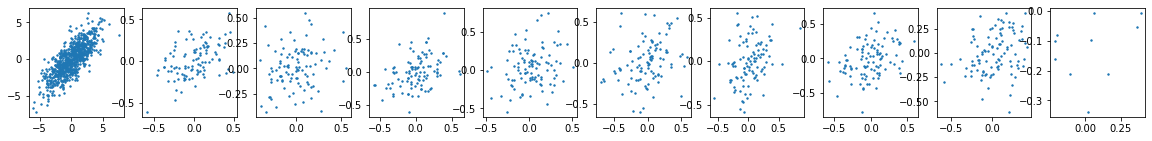

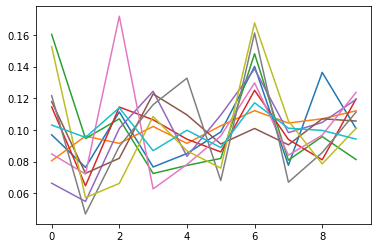

In [282]:

D_IN = 28*28
D_OUT = 10
WIDTH = 100
LAYERS = 100

RES = .0
BATCH_SIZE = 10
ACTIVATION = 'relu'
NORM = 'BN2'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlp = MyMLP(L=LAYERS,D=WIDTH,res=RES,activ=ACTIVATION, norm=NORM, D_in=D_IN, D_out=D_OUT)
mlp = mlp.to(device)

# X =  (torch.eye(BATCH_SIZE)+.0*torch.ones(BATCH_SIZE)) @ torch.rand(size=(BATCH_SIZE,D_IN))  # torch.normal(0, 1, size=(BATCH_SIZE,D_IN)) 
X =  (torch.eye(BATCH_SIZE)+.5*torch.ones(BATCH_SIZE)) @ torch.normal(0, 1, size=(BATCH_SIZE,D_IN)) 
X = X.to(device)
Hidden = mlp.full_forward(X)

p_tensor = torch.tensor(Hidden[-1])
p_tensor = torch.softmax(p_tensor,dim=1)
entropy = Categorical(probs = p_tensor).entropy()

print(entropy)
print(entropy.mean())

show_layers(Hidden,Num=10)
plt.figure()
plt.plot(p_tensor.transpose(0,1))

In [343]:
model.to('cpu')(train_data)

AttributeError: 'MNIST' object has no attribute 'view'